In [1]:
#This notebook performs Step 1 of the RNN training process: time-warping the single letter data so that it
#can be used to initialize the data-labeling HMM. Running this notebook will (slowly) time-warp all 10 sessions
#and save the results in Step1_TimeWarping folder.

#To run this notebook, you'll need the time warped PCA python package (https://github.com/ganguli-lab/twpca).

In [2]:
# import tensorflow as tf

# #suppress all tensorflow warnings (largely related to compatability with v2)
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import os
import numpy as np
import scipy.io
import scipy.ndimage.filters
import matplotlib.pyplot as plt
# from twpca import TWPCA
# from twpca.regularizers import curvature
from characterDefinitions import getHandwritingCharacterDefinitions

#point this towards the top level dataset directory
rootDir = os.path.expanduser('~') + '/handwritingBCIData/'

#this line ensures that tensorflow will only use GPU 0 (keeps it from taking over all the GPUs in a multi-gpu setup)
os.environ["CUDA_VISIBLE_DEVICES"]='0'

#defines all the sessions that will be time-warped
dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15']

#defines the list of all 31 characters and what to call them
charDef = getHandwritingCharacterDefinitions()

# #saves all time-warped data in this folder
# if not os.path.isdir(rootDir + 'RNNTrainingSteps/Step1_TimeWarping'):
#     os.mkdir(rootDir + 'RNNTrainingSteps/Step1_TimeWarping')

In [4]:
def load_data(dir_load, fileName_load, path_load=None):
    from pathlib import Path
    if path_load is None:
        dir_load = Path(dir_load).resolve()
        fileName_load = fileName_load
        path_load = dir_load / fileName_load

    dat = scipy.io.loadmat(path_load)
    return dat

In [5]:
dat = load_data(dir_load=r'/media/rich/bigSSD/NMA_data/Willet_data/Datasets/t5.2019.05.08',
               fileName_load=r'singleLetters.mat')

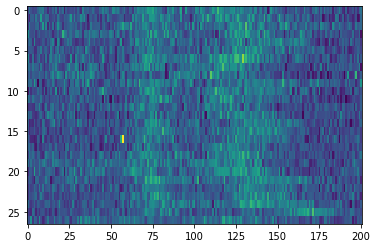

In [12]:
plt.figure()
# plt.imshow(np.mean(dat['neuralActivityCube_l'], axis=2), aspect='auto', interpolation='none')
plt.imshow(np.mean(dat['neuralActivityCube_g'], axis=2), aspect='auto', interpolation='none')

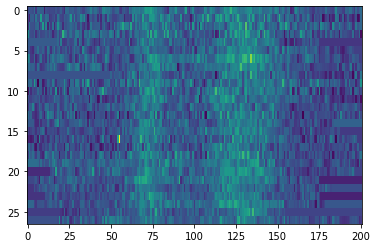

In [13]:
plt.figure()
# plt.imshow(np.mean(dat['neuralActivityCube_l'], axis=2), aspect='auto', interpolation='none')
plt.imshow(np.mean(alignedDat['g'], axis=2), aspect='auto', interpolation='none')

In [9]:
import sys
sys.path.append(r'/media/rich/Home_Linux_partition/github_repos/affinewarp')
from affinewarp import ShiftWarping, PiecewiseWarping

Warping dataset: t5.2019.05.08


Loss improvement: 0.01%:   0%|          | 0/50 [00:00<?, ?it/s]

Warping character: a


Loss improvement: 0.35%: 100%|██████████| 50/50 [00:05<00:00,  9.60it/s]


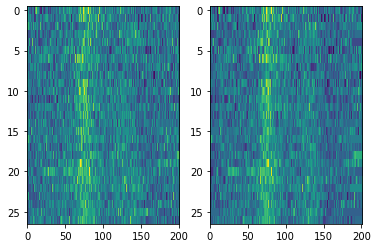

Loss improvement: 0.02%:   2%|▏         | 1/50 [00:00<00:05,  9.51it/s]

Warping character: b


Loss improvement: 0.23%: 100%|██████████| 50/50 [00:05<00:00,  9.61it/s]


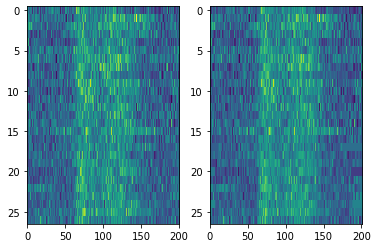

Loss improvement: 0.00%:   0%|          | 0/50 [00:00<?, ?it/s]

Warping character: c


Loss improvement: 0.13%: 100%|██████████| 50/50 [00:05<00:00,  9.71it/s]


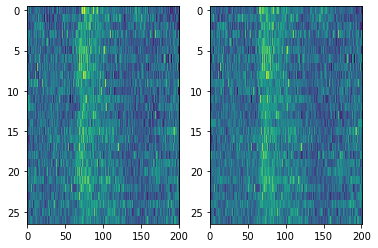

Loss improvement: 0.07%:   2%|▏         | 1/50 [00:00<00:05,  9.69it/s]

Warping character: d


Loss improvement: 0.45%: 100%|██████████| 50/50 [00:05<00:00,  9.44it/s]


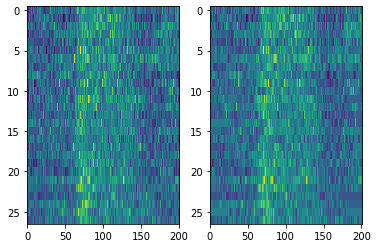

Loss improvement: 0.01%:   0%|          | 0/50 [00:00<?, ?it/s]

Warping character: e


Loss improvement: 0.38%: 100%|██████████| 50/50 [00:05<00:00,  9.68it/s]


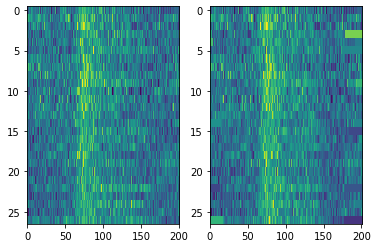

Loss improvement: 0.01%:   0%|          | 0/50 [00:00<?, ?it/s]

Warping character: f


Loss improvement: 0.24%: 100%|██████████| 50/50 [00:05<00:00,  9.36it/s]


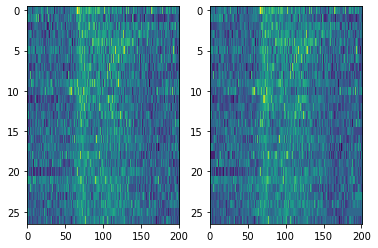

Loss improvement: 0.11%:   0%|          | 0/50 [00:00<?, ?it/s]

Warping character: g


Loss improvement: 0.72%:  82%|████████▏ | 41/50 [00:04<00:00,  9.84it/s]

In [ ]:
%matplotlib inline

#Time-warp all singleLetters.mat files and save them to the Step1_TimeWarping folder
for dataDir in dataDirs:
    
    print('Warping dataset: ' + dataDir)
#     dat = scipy.io.loadmat(rootDir+'Datasets/'+dataDir+'/singleLetters.mat')
    dat = load_data(dir_load=r'/media/rich/bigSSD/NMA_data/Willet_data/Datasets/t5.2019.05.08',
               fileName_load=r'singleLetters.mat')

    #Because baseline firing rates drift over time, we normalize each electrode's firing rate by subtracting
    #its mean firing rate within each block of data (re-centering it). We also divide by each electrode's standard deviation 
    #to normalize the units.
    for char in charDef['charList']:
        neuralCube = dat['neuralActivityCube_'+char].astype(np.float64)

        #get the trials that belong to this character
        trlIdx = []
        for t in range(dat['characterCues'].shape[0]):
            if dat['characterCues'][t,0]==char:
                trlIdx.append(t)

        #get the block that each trial belonged to
        blockIdx = dat['blockNumsTimeSeries'][dat['goPeriodOnsetTimeBin'][trlIdx]]
        blockIdx = np.squeeze(blockIdx)

        #subtract block-specific means from each trial 
        for b in range(dat['blockList'].shape[0]):
            trialsFromThisBlock = np.squeeze(blockIdx==dat['blockList'][b])
            neuralCube[trialsFromThisBlock,:,:] -= dat['meansPerBlock'][np.newaxis,b,:]

        #divide by standard deviation to normalize the units
        neuralCube = neuralCube / dat['stdAcrossAllData'][np.newaxis,:,:]

        #replace the original cube with this newly normalized one
        dat['neuralActivityCube_'+char] = neuralCube
    
    alignedDat = {}
    
    #The following warps each character one at a time. 
    #(this is slow, and could be sped up significantly by warping multiple characters in parallel)
    for char in charDef['charList']:
        print('Warping character: ' + char)

#         #Clears the previous character's graph
#         tf.reset_default_graph()

#         #Number of factors used to denoise the data while time-warping (by approximating data with low-rank matrices)
#         n_components = 5

#         #Adds an L1 penalty on the second order finite difference of the warping functions.
#         #This encourages the warping functions to be piecewise linear.
#         warp_regularizer = curvature(scale=0.001, power=1)

#         #Adds an L2 penatly on the second order finite difference of the temporal factors.
#         #Encourages the temporal factors to be smooth in time.
#         time_regularizer = curvature(scale=1.0, power=2, axis=0)

#         # Smooths the binned spike counts before time-warping to denoise them (this step is key!)
#         smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+char], 3.0, axis=1)

#         # fit time-warping model
#         model = TWPCA(smoothed_spikes, 
#                       n_components, 
#                       warp_regularizer=warp_regularizer, 
#                       time_regularizer=time_regularizer).fit(progressbar=False)

        model = PiecewiseWarping(n_knots=0, warp_reg_scale=1e-6, smoothness_reg_scale=20.0)
        model.fit(dat['neuralActivityCube_'+char])
    
        # use the model object to align data 
        estimated_aligned_data = model.transform(dat['neuralActivityCube_'+char])
        smoothed_aligned_data = scipy.ndimage.filters.gaussian_filter1d(estimated_aligned_data, 3.0, axis=1)

        #store aligned data and time-warping functions
        alignedDat[char] = estimated_aligned_data
#         alignedDat[char+'_T'] = model.params['warp'].T.copy()
        alignedDat[char+'_T'] = model.template

        #only make plots for the first session (otherwise the notebook gets too big)
        if dataDir!='t5.2019.05.08':
            continue
            
        #plot the warping functions to make sure they look reasonable (should be subtle deviations from the identity line)
        fig, axs = plt.subplots(1,2)
        axs[0].imshow(np.mean(dat['neuralActivityCube_'+char], axis=2), aspect='auto', interpolation='none')
        axs[1].imshow(np.mean(alignedDat[char], axis=2), aspect='auto', interpolation='none')
#         plt.figure(figsize=(14,4))
#         plt.subplot(1,3,1)
# #         plt.plot(model.params['warp'].T, alpha=1);
#         plt.plot(alignedDat[char+'_T']);
# #         plt.axis('square')
#         plt.xlabel('Clock time')
#         plt.ylabel('Aligned time')
# #         plt.xlim(0, model.params['warp'].T.shape[0]);
# #         plt.ylim(0, model.params['warp'].T.shape[0])
#         plt.xlim(0, alignedDat[char+'_T'].shape[0]);
# #         plt.ylim(0, alignedDat[char+'_T'].shape[0])
#         plt.title('Learned warping functions')
        
        #It's helpful also to visualize how the major dimensions in the data were aligned
        #We chose dimension 2 here, because the top dimension isn't as informative (it's just a large spike at movement onset)
#         neuron_factors = model.params['neuron']
#         plt.subplot(1,3,2)
#         for t in range(estimated_aligned_data.shape[0]):
#             thisTrialActivity = np.matmul(smoothed_spikes[t,:,:], neuron_factors)
#             plt.plot(thisTrialActivity[:,1])
            
#         plt.title('Unwarped Trials')
#         plt.xlabel('Time Step (10 ms)')
#         plt.ylabel('Activity in Top Neural Dimension #2')
        
#         plt.subplot(1,3,3)
#         for t in range(estimated_aligned_data.shape[0]):
#             thisTrialWarpedActivity = np.matmul(smoothed_aligned_data[t,:,:], neuron_factors)
#             plt.plot(thisTrialWarpedActivity[:,1])
        
#         plt.title('Warped Trials')
#         plt.xlabel('Time Step (10 ms)')
#         plt.ylabel('Activity in Top Neural Dimension #2')
        
        plt.show()
        
    #save time-warped characters as a .mat file        
    fileName = '/media/rich/bigSSD/NMA_data/Willet_data/Datasets/' + dataDir + '_warpedCubes.mat'
    print('Saving ' + fileName)
    scipy.io.savemat(fileName, alignedDat)
    

<IPython.core.display.Javascript object>


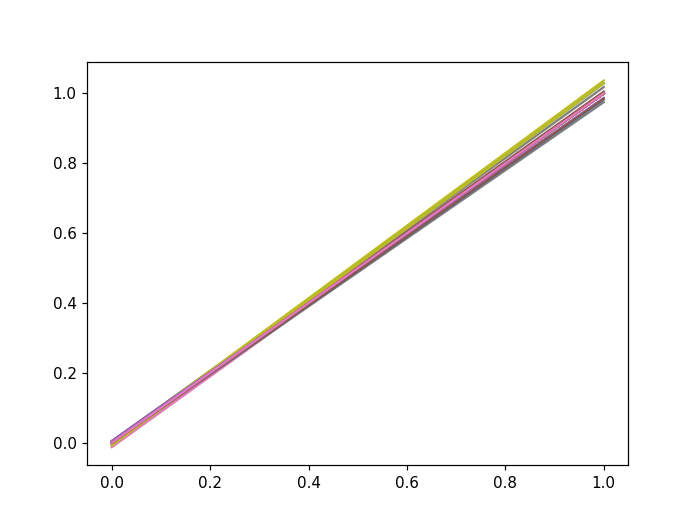

In [94]:
plt.figure()
for ii in range(model.x_knots.shape[0]):
    plt.plot(model.x_knots[ii], model.y_knots[ii])

<IPython.core.display.Javascript object>


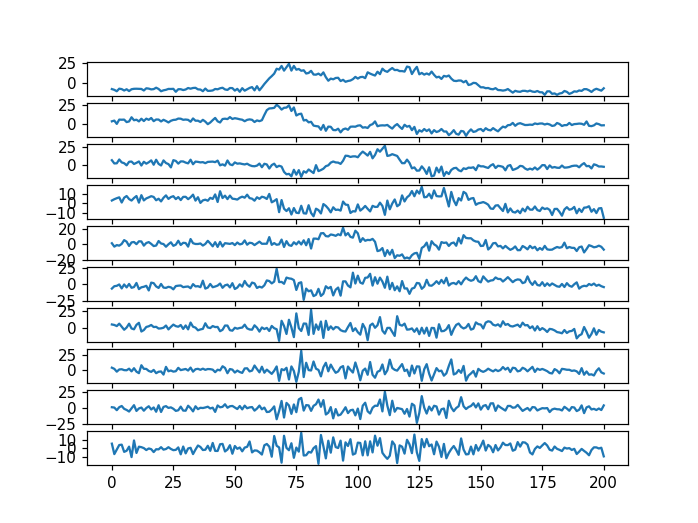

In [17]:
%matplotlib notebook

shp = alignedDat['b'].shape
# shp = dat['neuralActivityCube_b'].shape
arr_2d = np.reshape(alignedDat['b'].transpose(1,2,0), (shp[1], shp[0]*shp[2]))
# arr_2d = np.reshape(dat['neuralActivityCube_b'].transpose(1,2,0), (shp[1], shp[0]*shp[2]))


import sklearn.decomposition
pca = sklearn.decomposition.PCA(n_components=10)
test = pca.fit_transform(arr_2d)

fig, axs = plt.subplots(test.shape[1])

for ii in range(len(axs)):
    axs[ii].plot(test[:,ii])